In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas_datareader as prd

In [2]:
# Loading datasets from the data directory
drivers = pd.read_csv('data/drivers.csv')
constructors = pd.read_csv('data/constructors.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')
qualifying = pd.read_csv('data/qualifying.csv')
circuits = pd.read_csv('data/circuits.csv')
lap_times = pd.read_csv('data/lap_times.csv')
pit_stops = pd.read_csv('data/pit_stops.csv')
constructor_standings = pd.read_csv('data/constructor_standings.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
constructor_results = pd.read_csv('data/constructor_results.csv')
seasons = pd.read_csv('data/seasons.csv')
status = pd.read_csv('data/status.csv')

In [3]:
# Merge results with races
df = pd.merge(results, races, on='raceId', how='left')

# Merge with drivers
df = pd.merge(df, drivers, on='driverId', how='left', suffixes=('', '_driver'))

# Merge with constructors
df = pd.merge(df, constructors, on='constructorId', how='left', suffixes=('', '_constructor'))

# Merge with circuits
df = pd.merge(df, circuits, on='circuitId', how='left', suffixes=('', '_circuit'))

# Merge with qualifying results
df = pd.merge(df, qualifying, on=['raceId', 'driverId', 'constructorId'], how='left', suffixes=('', '_qualifying'))

In [4]:
# missing_values = df.isnull().sum()
# missing_values[missing_values > 0]
df = df.dropna(subset=['positionOrder', 'position_qualifying'])

In [5]:
df.loc[:, 'winner'] = df['positionOrder'].apply(lambda x: 1 if x == 1 else 0)

In [6]:
df = df.sort_values(by=['driverId', 'year', 'round'])

In [7]:
df['driver_race_count'] = df.groupby('driverId').cumcount()

In [8]:
df['driver_season_points'] = df.groupby(['driverId', 'year'])['points'].cumsum() - df['points']

In [9]:
df['constructor_season_points'] = df.groupby(['constructorId', 'year'])['points'].cumsum() - df['points']

In [10]:
df['qualifying_position'] = df['position_qualifying']

In [11]:
df = df.sort_values(by=['driverId', 'year', 'round'])

In [12]:
df['avg_qualifying_position'] = df.groupby(['driverId', 'year'])['qualifying_position'].transform(
    lambda x: x.expanding().mean().shift(1)
)

In [13]:
# Combine driver and constructor nationalities
df['driver_nationality'] = df['nationality']
df['constructor_nationality'] = df['nationality_constructor']
# Encode categorical variables using one-hot encoding
categorical_cols = [
    'driver_nationality',
    'constructor_nationality',
    'circuitId',
    'statusId',
    'country',
]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [14]:
feature_cols = [
    'driver_race_count',
    'driver_season_points',
    'constructor_season_points',
    'qualifying_position',
    'avg_qualifying_position',
    # Include one-hot encoded columns
] + [col for col in df.columns if 'driver_nationality_' in col or 'constructor_nationality_' in col]

# Final feature set
X = df[feature_cols]
y = df['winner']

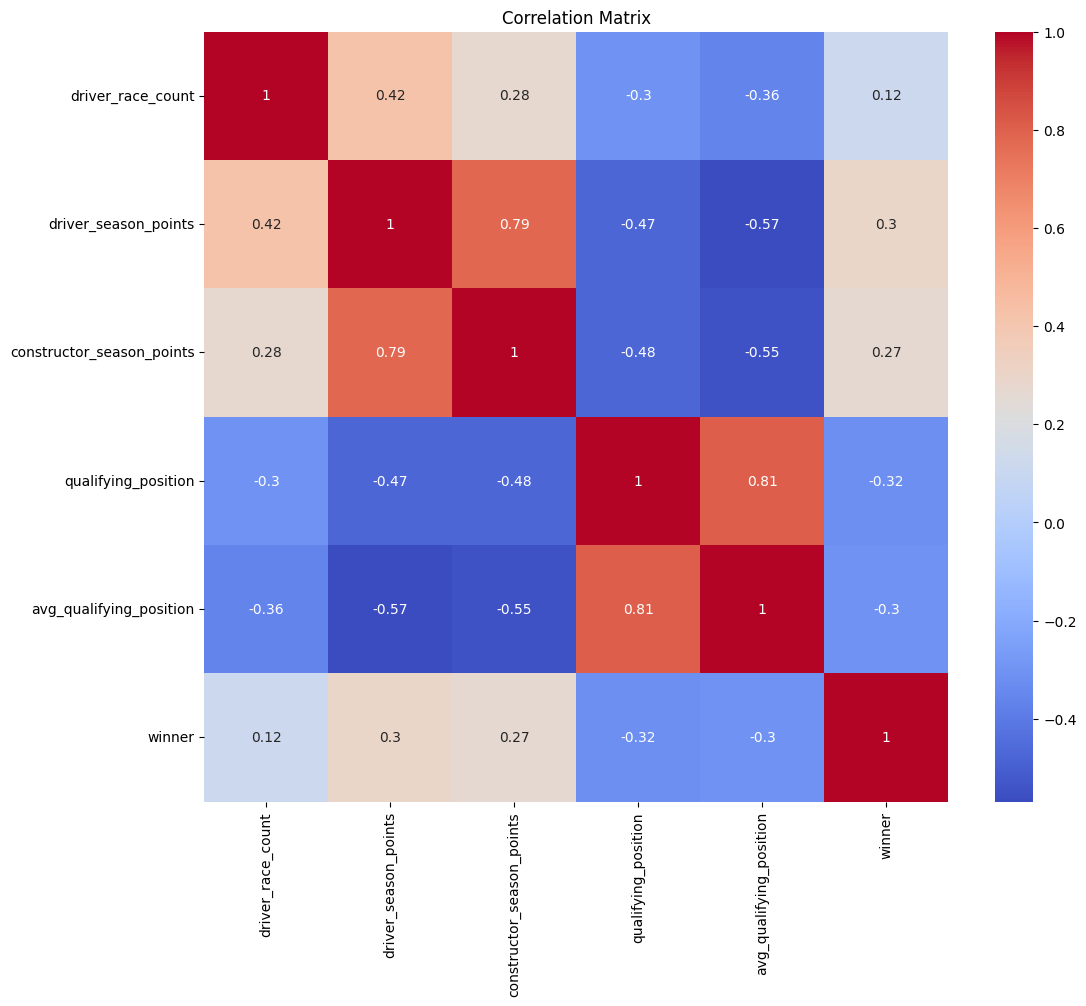

In [15]:
# Compute correlation matrix
corr_matrix = df[feature_cols + ['winner']].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

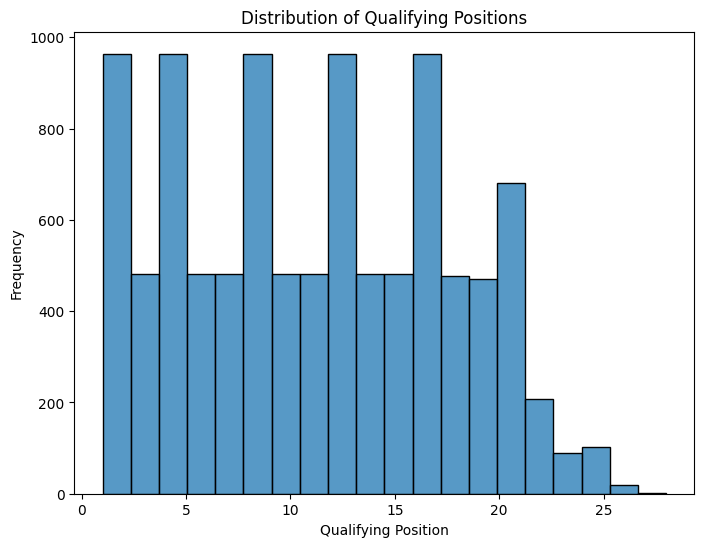

In [16]:
# Distribution of qualifying positions
plt.figure(figsize=(8, 6))
sns.histplot(df['qualifying_position'], bins=20, kde=False)
plt.title('Distribution of Qualifying Positions')
plt.xlabel('Qualifying Position')
plt.ylabel('Frequency')
plt.show()

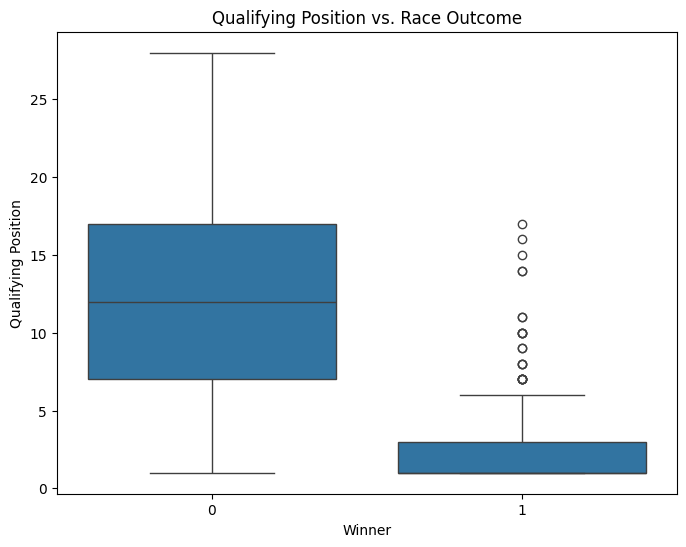

In [17]:
# Relationship between qualifying position and winning
plt.figure(figsize=(8, 6))
sns.boxplot(x='winner', y='qualifying_position', data=df)
plt.title('Qualifying Position vs. Race Outcome')
plt.xlabel('Winner')
plt.ylabel('Qualifying Position')
plt.show()

In [18]:
# Fill missing values with median
X = X.fillna(X.median())

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

C:\Users\ishan\OneDrive\Desktop\f1_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [24]:
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy: {:.2f}%".format(accuracy_lr * 100))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 95.66%
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1953
           1       0.71      0.12      0.21        96

    accuracy                           0.96      2049
   macro avg       0.83      0.56      0.60      2049
weighted avg       0.95      0.96      0.94      2049



In [25]:
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy: {:.2f}%".format(accuracy_rf * 100))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 95.46%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1953
           1       0.53      0.27      0.36        96

    accuracy                           0.95      2049
   macro avg       0.75      0.63      0.67      2049
weighted avg       0.94      0.95      0.95      2049



In [26]:
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy: {:.2f}%".format(accuracy_xgb * 100))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 95.61%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1953
           1       0.55      0.33      0.42        96

    accuracy                           0.96      2049
   macro avg       0.76      0.66      0.70      2049
weighted avg       0.95      0.96      0.95      2049



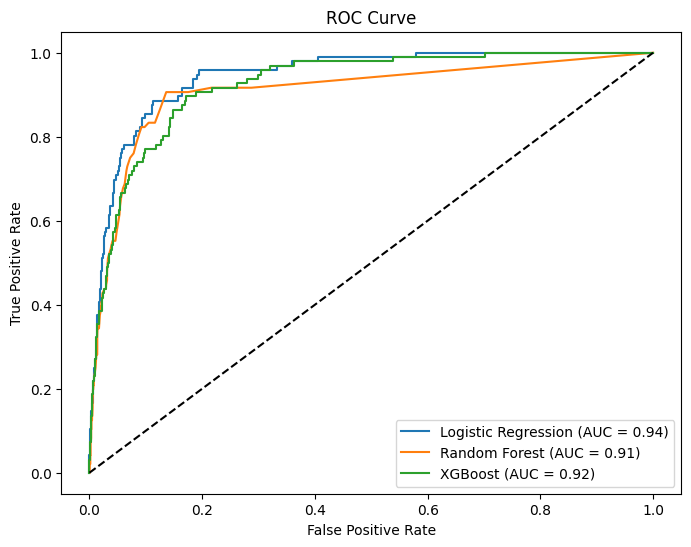

In [27]:
# Plot ROC curves
models = {
    'Logistic Regression': (lr, y_pred_lr),
    'Random Forest': (rf, y_pred_rf),
    'XGBoost': (xgb, y_pred_xgb),
}

plt.figure(figsize=(8, 6))
for name, (model, _) in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(name, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [30]:
# Define parameter distributions
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random parameter combinations to try
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)

# Best estimator
best_rf = random_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\ishan\OneDrive\Desktop\f1_env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
21 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ishan\OneDrive\Desktop\f1_env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ishan\OneDrive\Desktop\f1_env\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\ishan\OneDrive\Desktop\f1_env\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constrai

Best parameters found:  {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': 5}


In [31]:
y_pred_best_rf = best_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Tuned Random Forest Accuracy: {:.2f}%".format(accuracy_best_rf * 100))
print(classification_report(y_test, y_pred_best_rf))

Tuned Random Forest Accuracy: 95.56%
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1953
           1       0.57      0.22      0.32        96

    accuracy                           0.96      2049
   macro avg       0.77      0.61      0.65      2049
weighted avg       0.94      0.96      0.95      2049



Feature ranking:
1. qualifying_position (0.513)
2. avg_qualifying_position (0.258)
3. driver_season_points (0.099)
4. constructor_season_points (0.076)
5. driver_race_count (0.053)


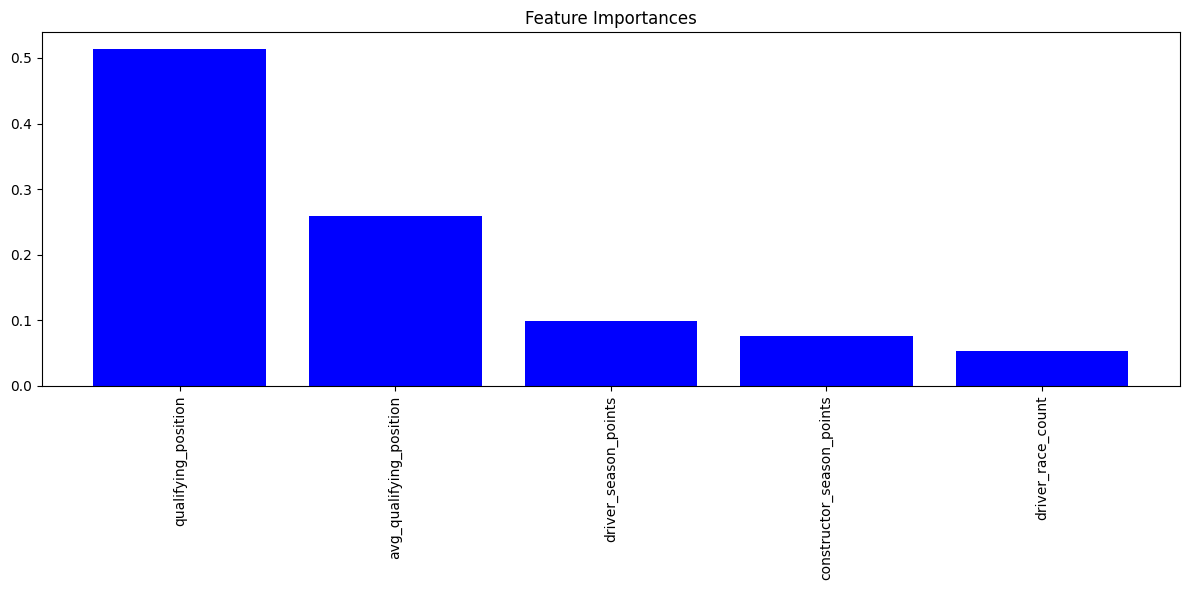

In [34]:
# Get feature importances
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for i in range(len(importances)):
    print("{}. {} ({:.3f})".format(i + 1, X.columns[indices[i]], importances[indices[i]]))

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), [X.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()